In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
from scipy.stats import entropy

import random
from math import ceil

import warnings

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [4]:
classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [5]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [8]:
def train(dataloader, model, loss_fn, optimizer):

  size = len(dataloader.dataset)
  model.train()

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)

    #### Prediction History - Our Class
        
    TrainingDynamicsViz.batch_accumulate(pred,batch,y)

    ##Calculate LOSS
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
        loss, current = loss.item(), batch * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


  ### add prediction history of this epoch to full history
      
  TrainingDynamicsViz.epoch_accumulate()

In [9]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
import sys
sys.path.append('..')

In [11]:
from VTDA import tdyn

In [12]:
epochs = 25

TrainingDynamicsViz= tdyn.TrainingDynamics(training_data.targets.cpu().numpy(), classes, device)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    
TrainingDynamicsViz.calculate()

print("Done!")

Epoch 1
-------------------------------
loss: 2.313634  [    0/60000]
loss: 2.299412  [ 6400/60000]
loss: 2.281983  [12800/60000]
loss: 2.264102  [19200/60000]
loss: 2.246810  [25600/60000]
loss: 2.233396  [32000/60000]
loss: 2.231605  [38400/60000]
loss: 2.199613  [44800/60000]
loss: 2.202496  [51200/60000]
loss: 2.157269  [57600/60000]
Test Error: 
 Accuracy: 45.0%, Avg loss: 2.159360 

Epoch 2
-------------------------------
loss: 2.182443  [    0/60000]
loss: 2.170678  [ 6400/60000]
loss: 2.108876  [12800/60000]
loss: 2.109357  [19200/60000]
loss: 2.068745  [25600/60000]
loss: 2.016768  [32000/60000]
loss: 2.037968  [38400/60000]
loss: 1.954901  [44800/60000]
loss: 1.973998  [51200/60000]
loss: 1.883007  [57600/60000]
Test Error: 
 Accuracy: 54.1%, Avg loss: 1.888672 

Epoch 3
-------------------------------
loss: 1.936195  [    0/60000]
loss: 1.903586  [ 6400/60000]
loss: 1.776225  [12800/60000]
loss: 1.802434  [19200/60000]
loss: 1.703248  [25600/60000]
loss: 1.655601  [32000/600

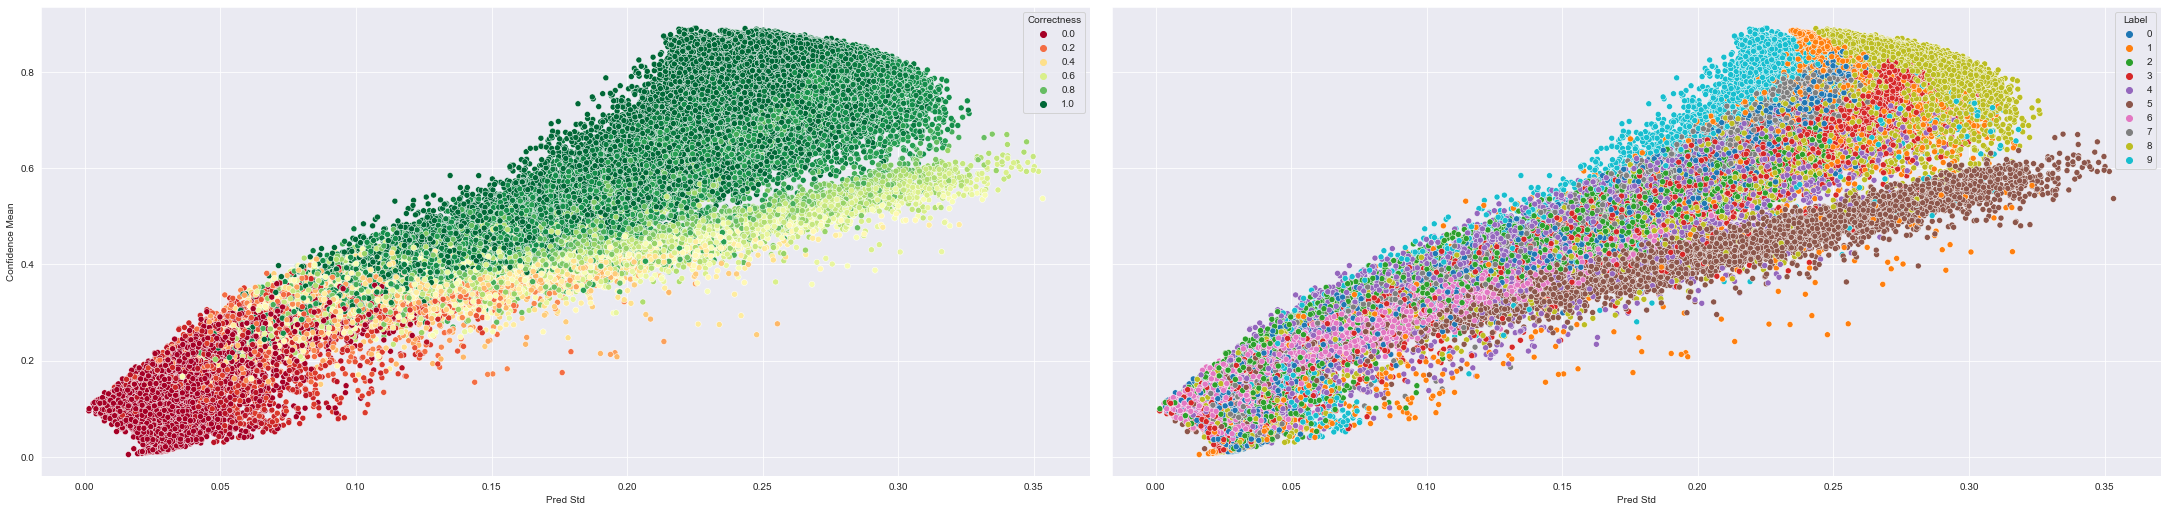

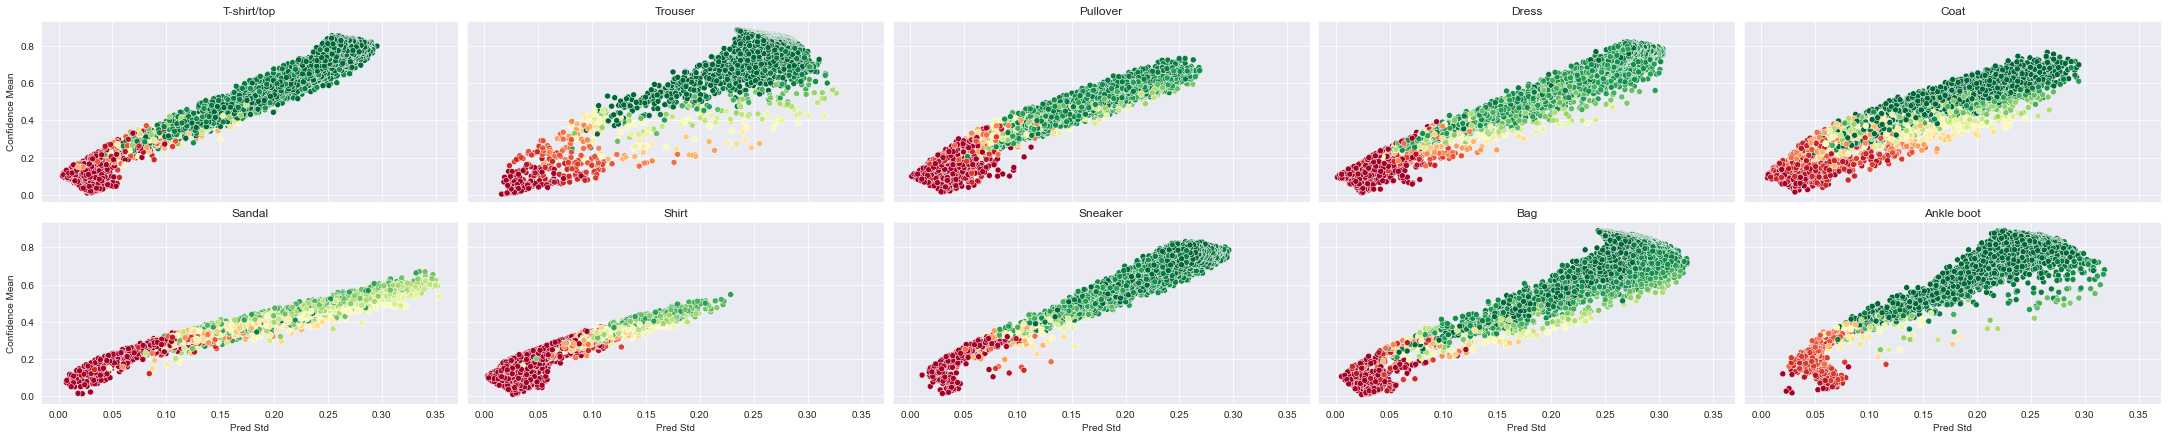

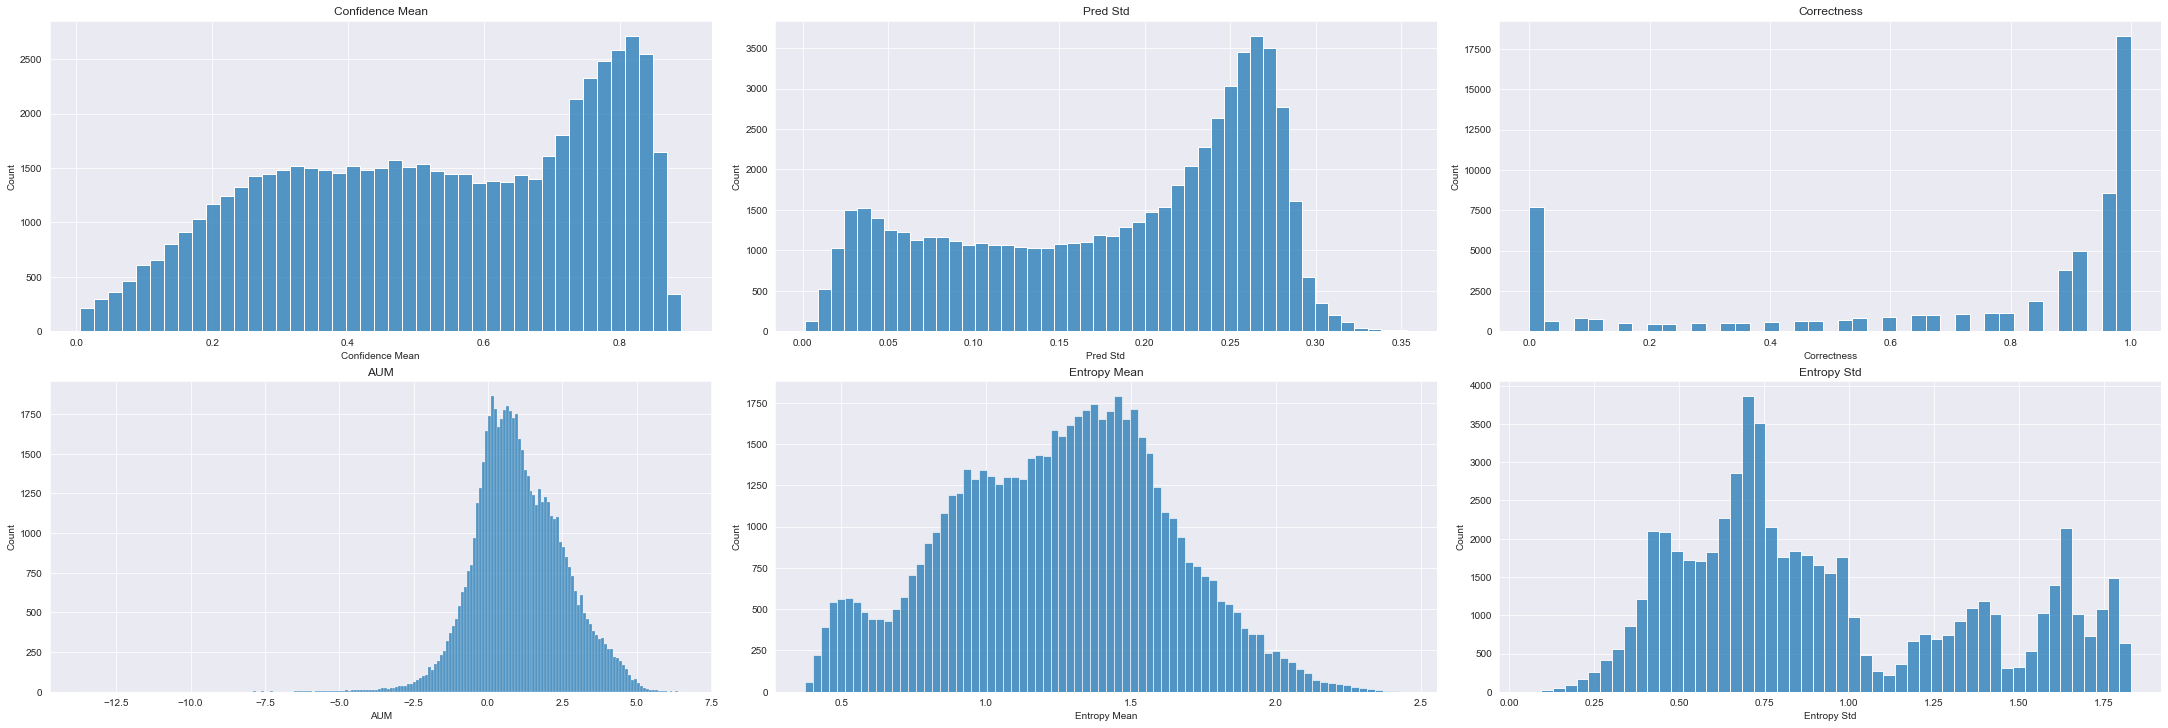

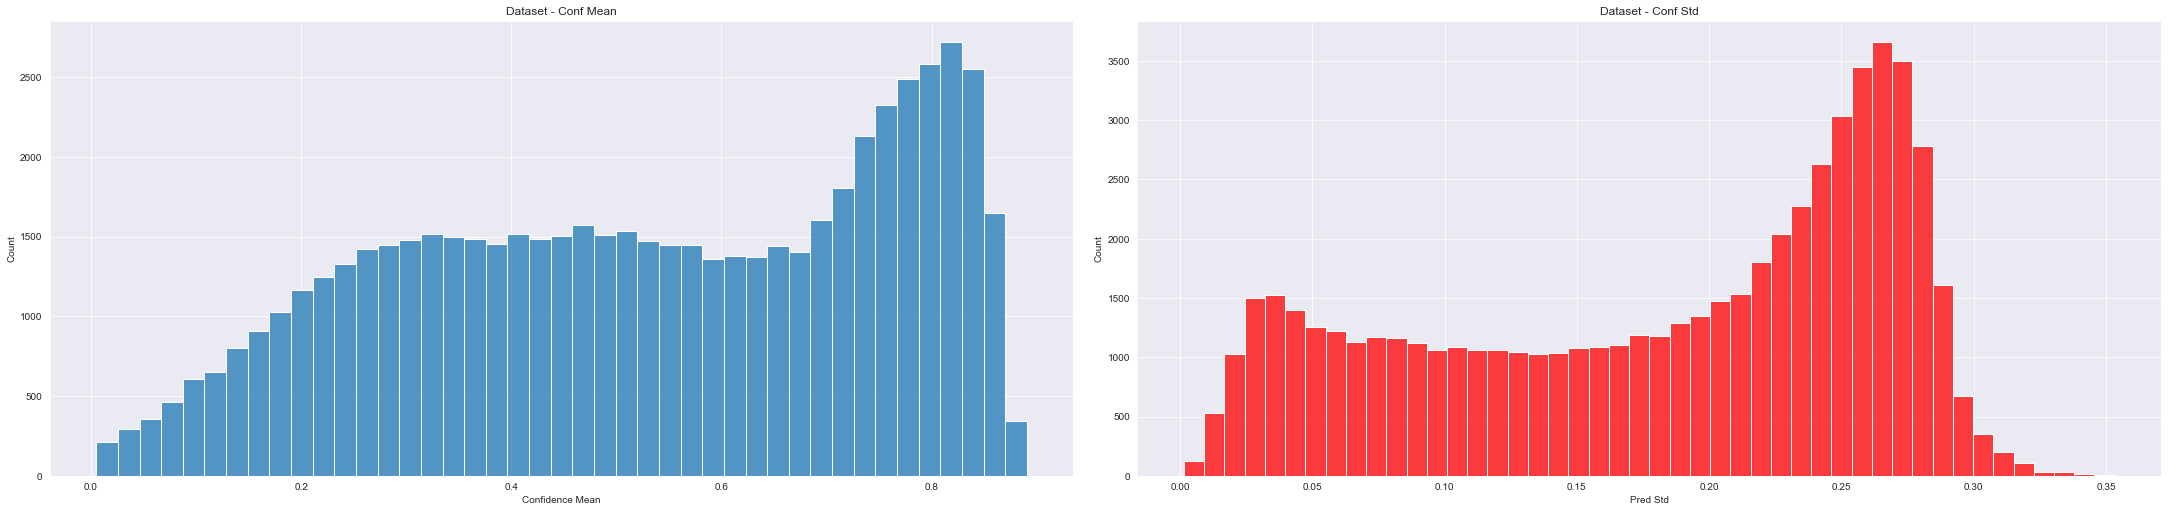

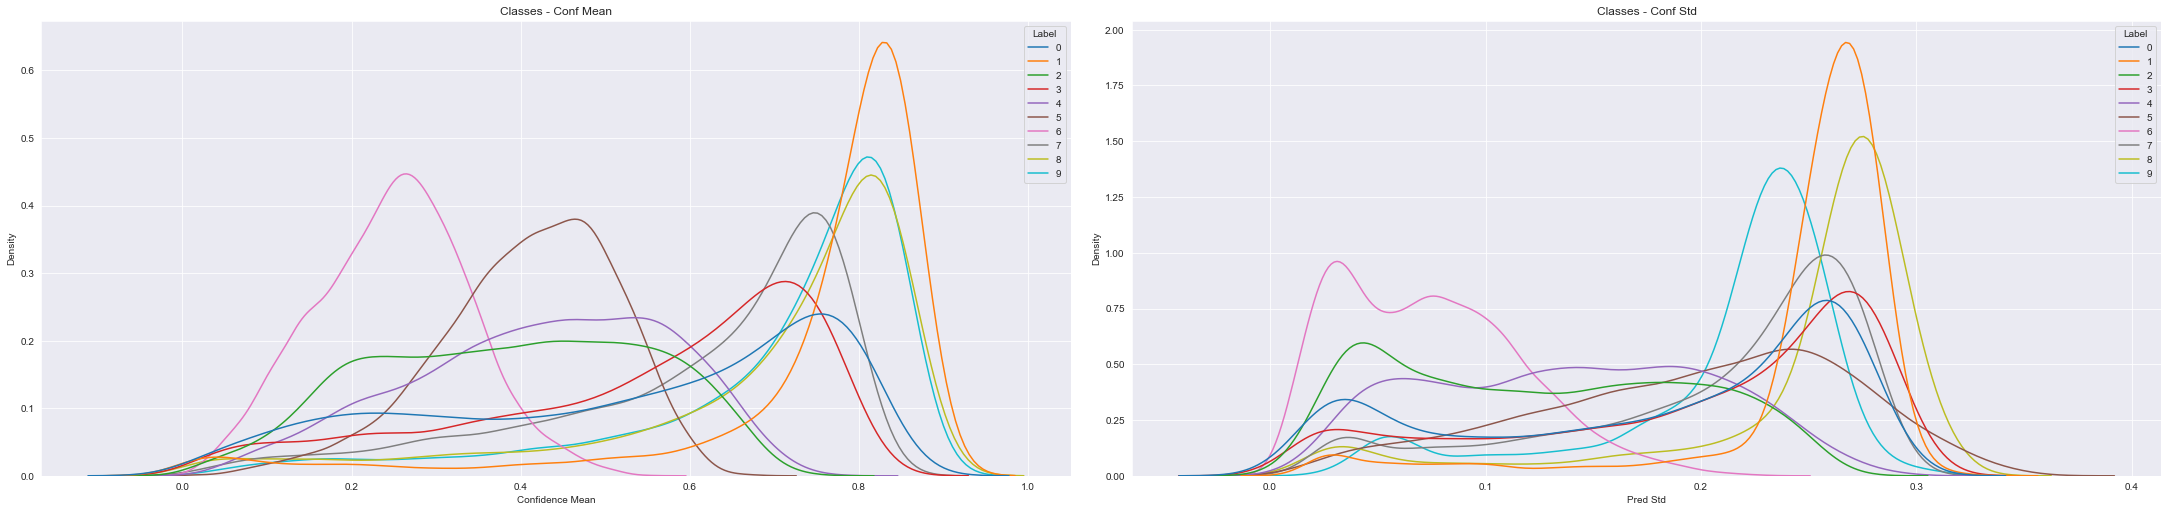

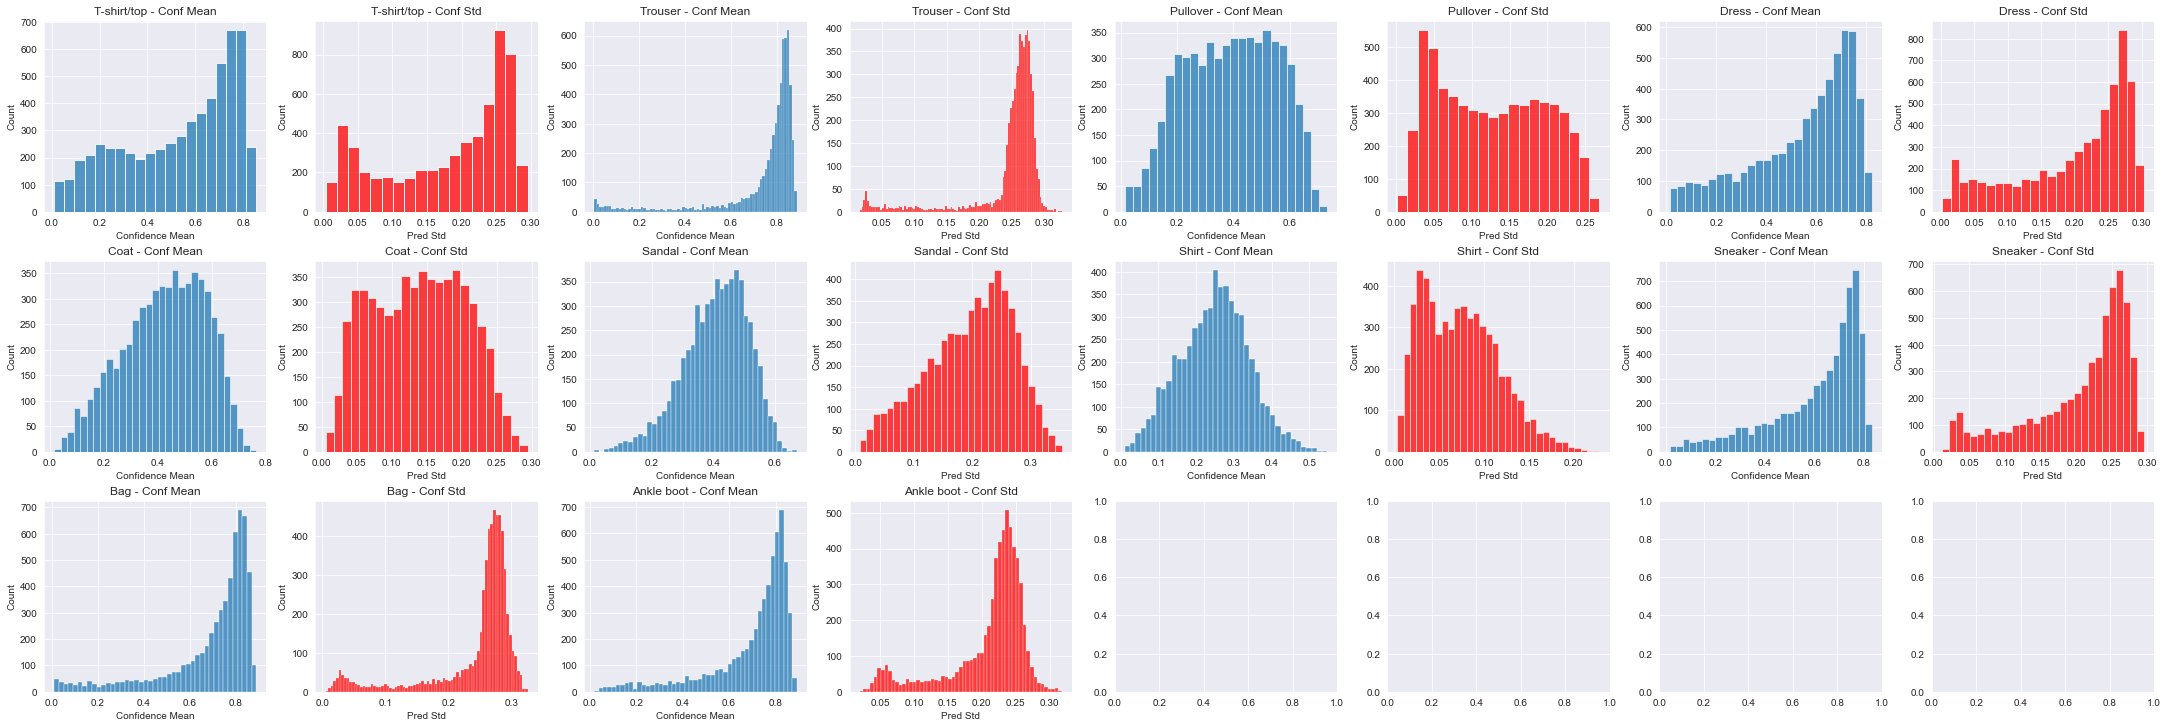

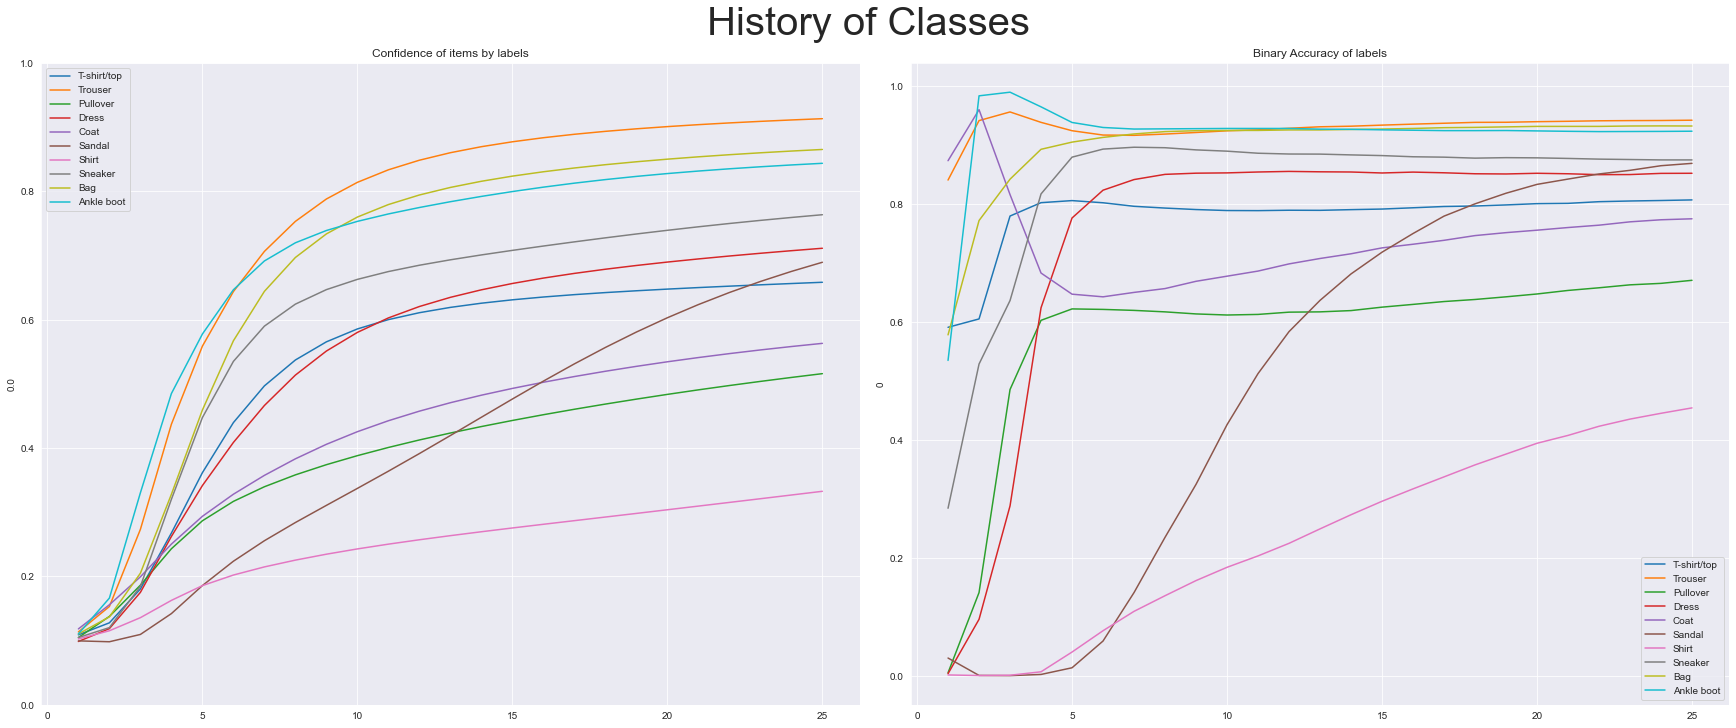

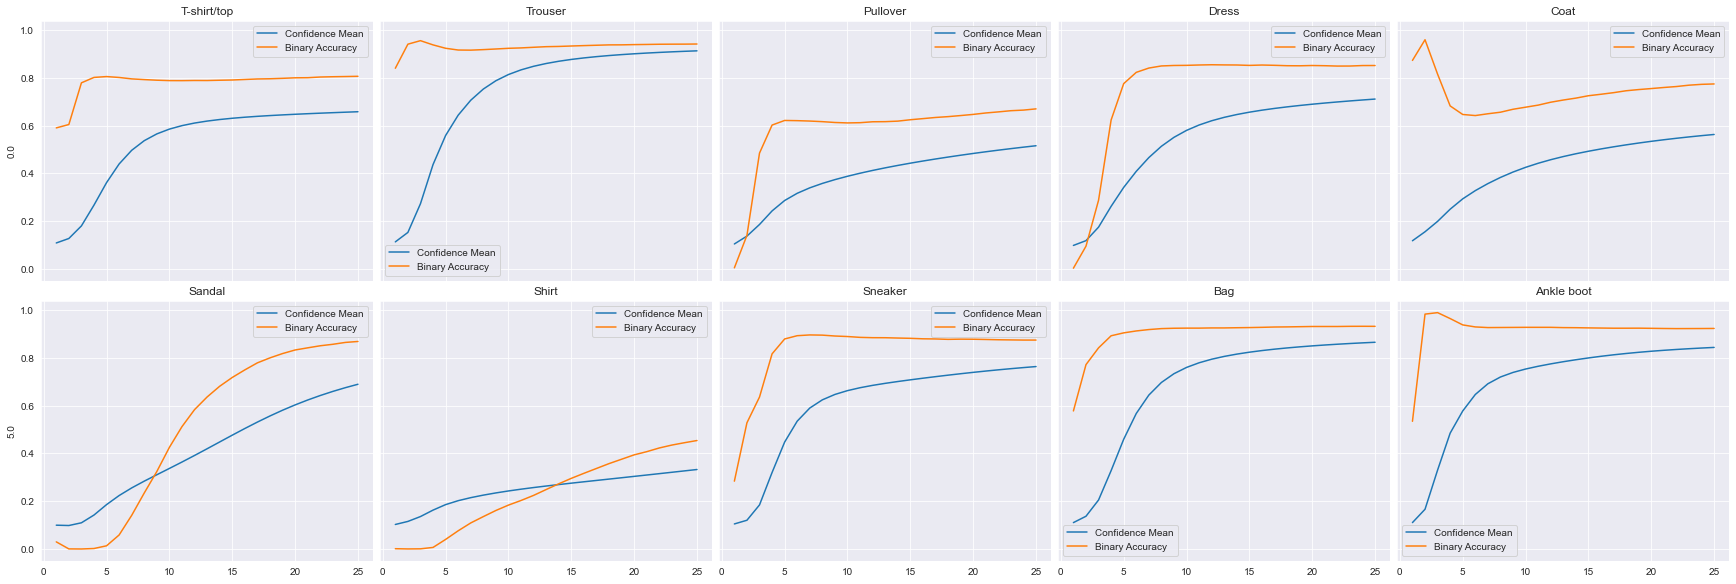

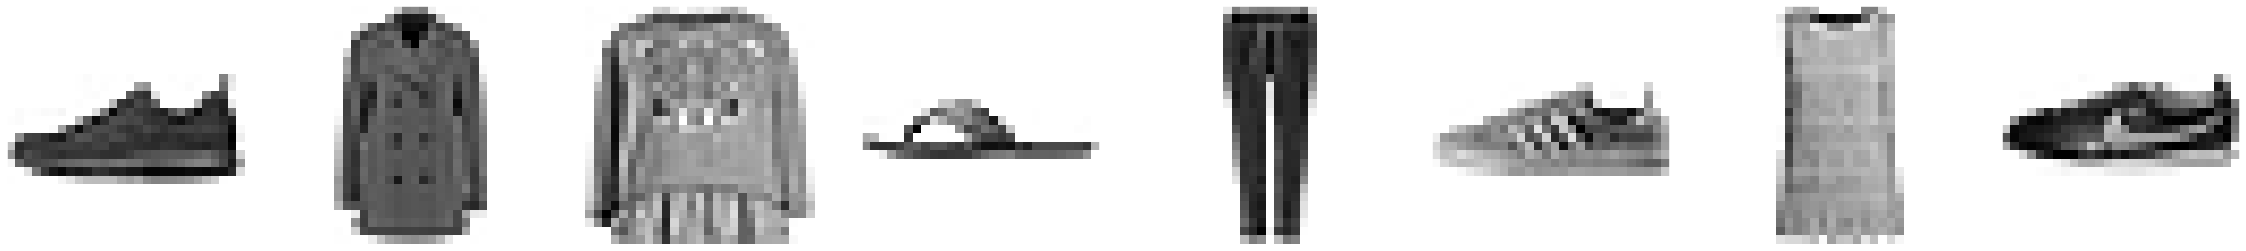

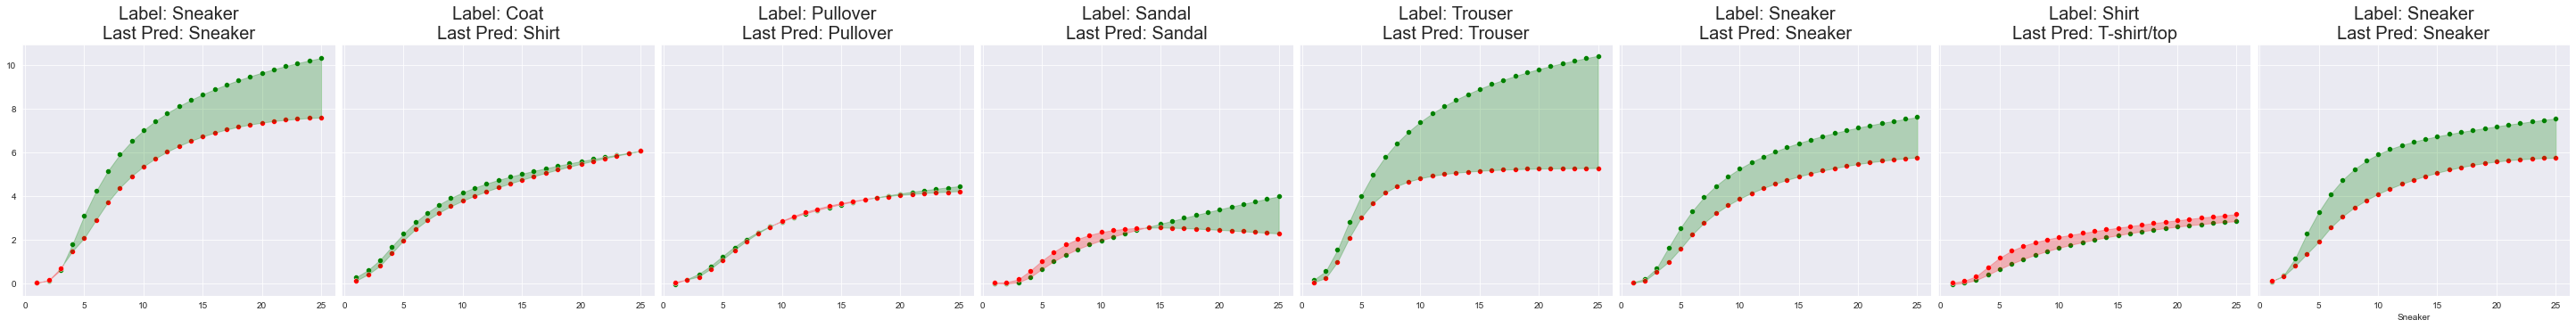

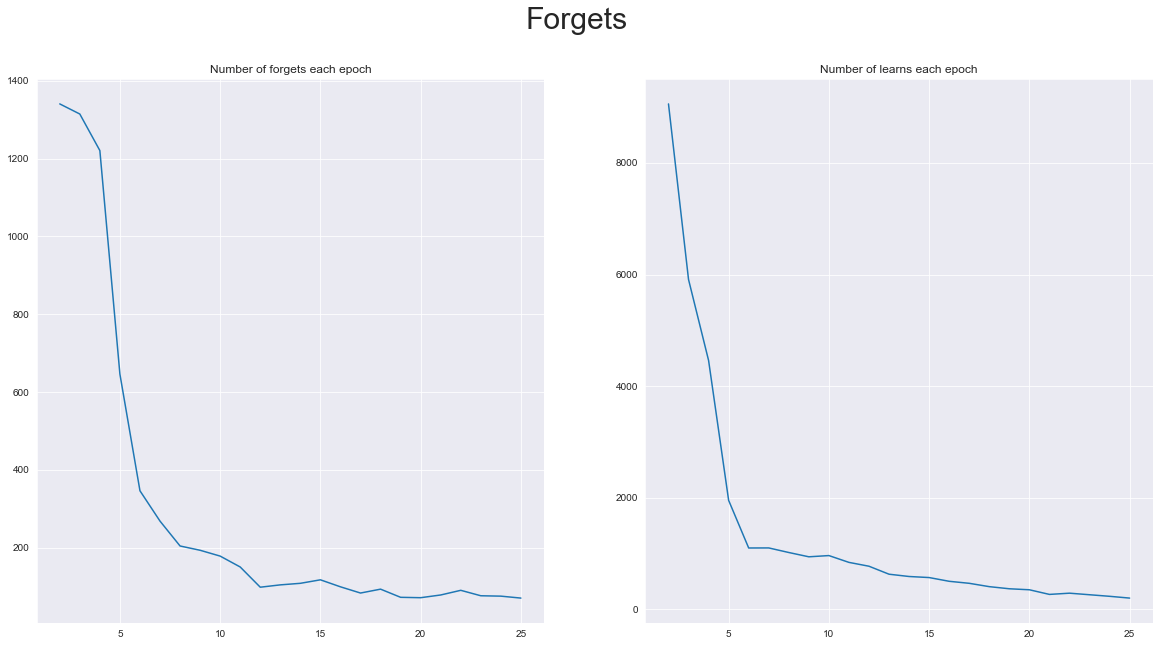

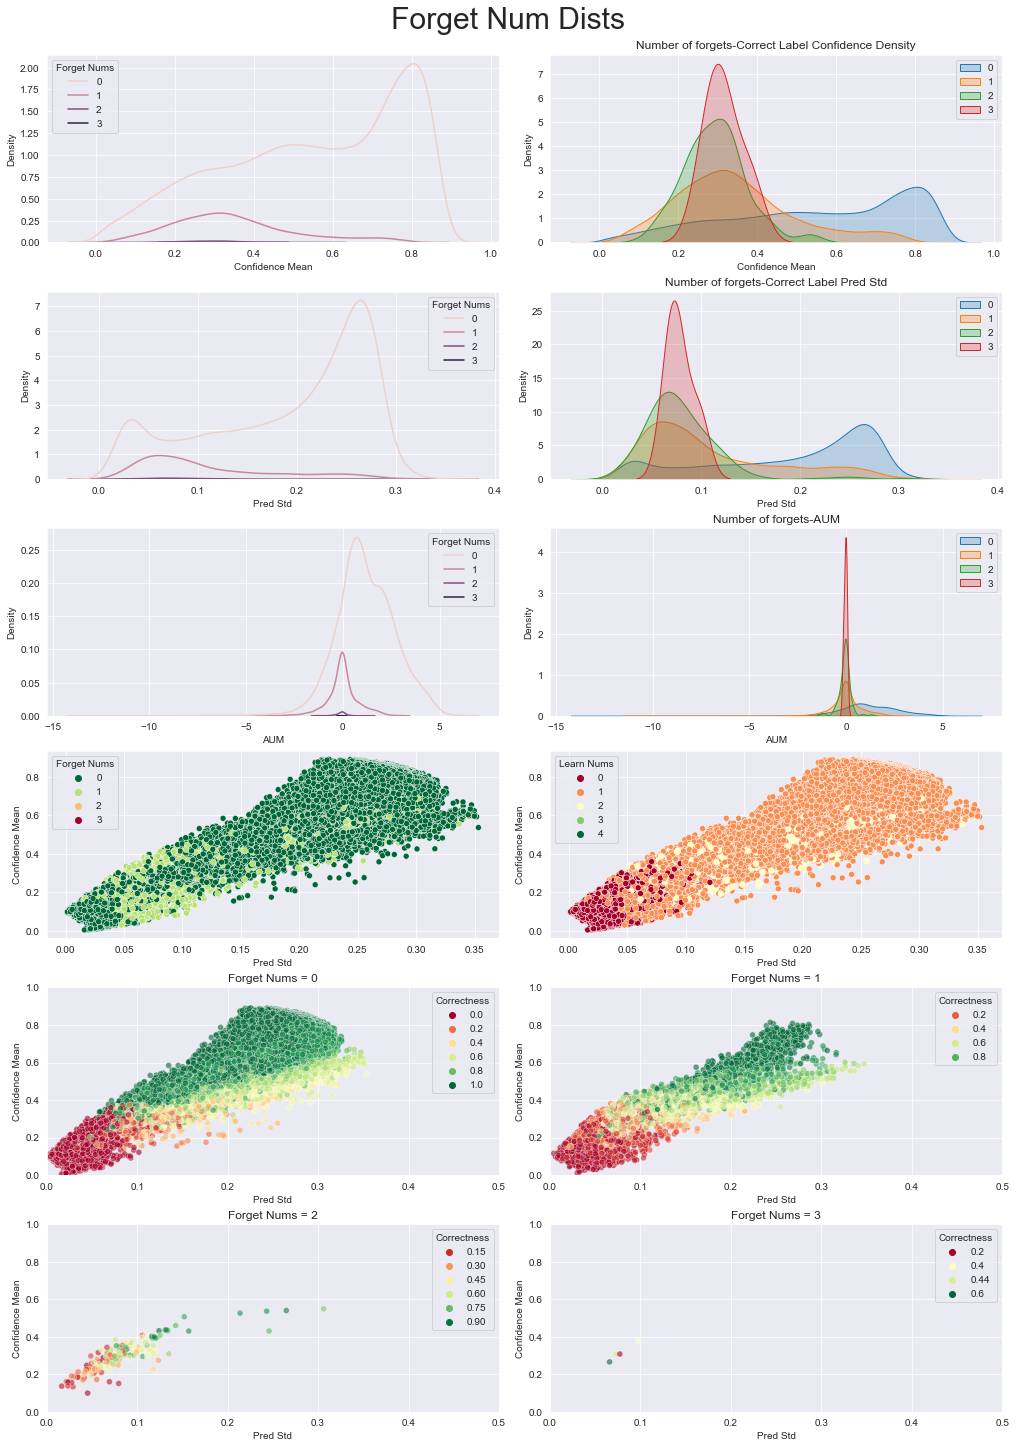

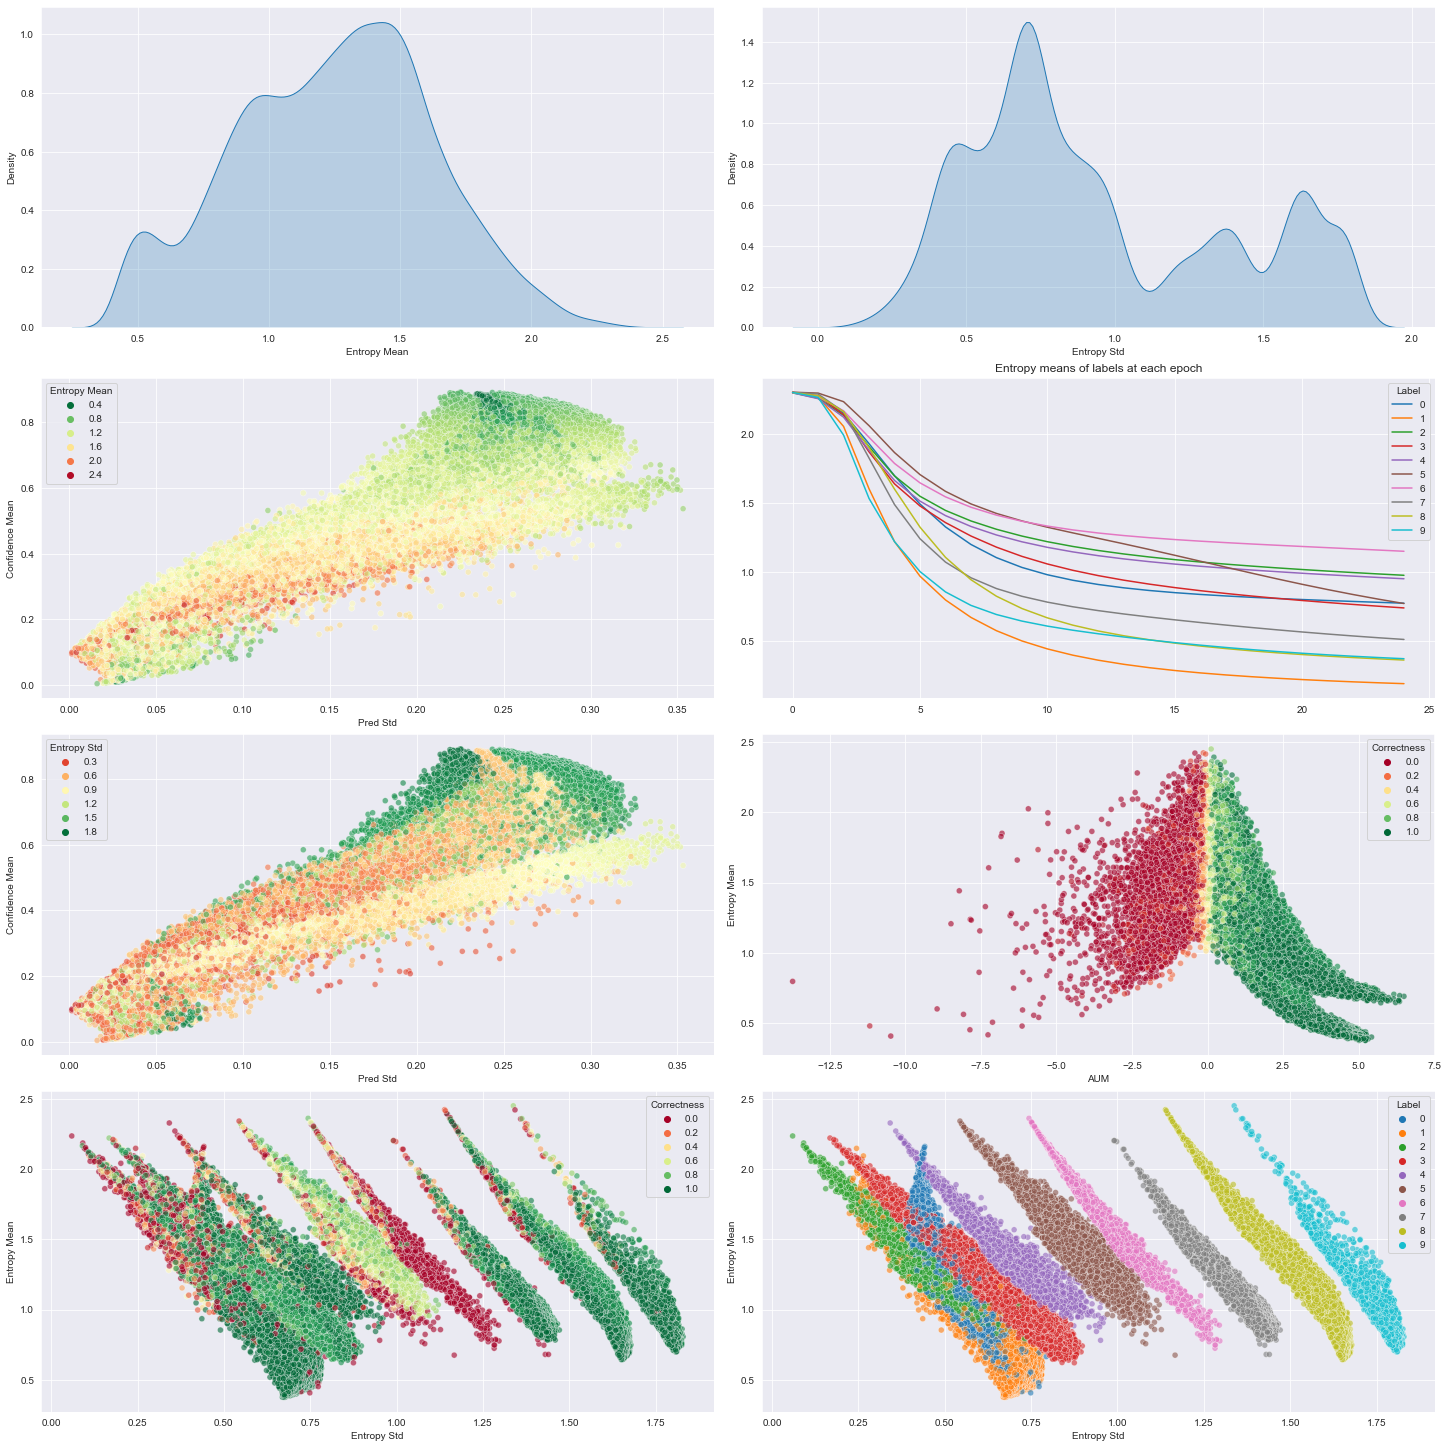

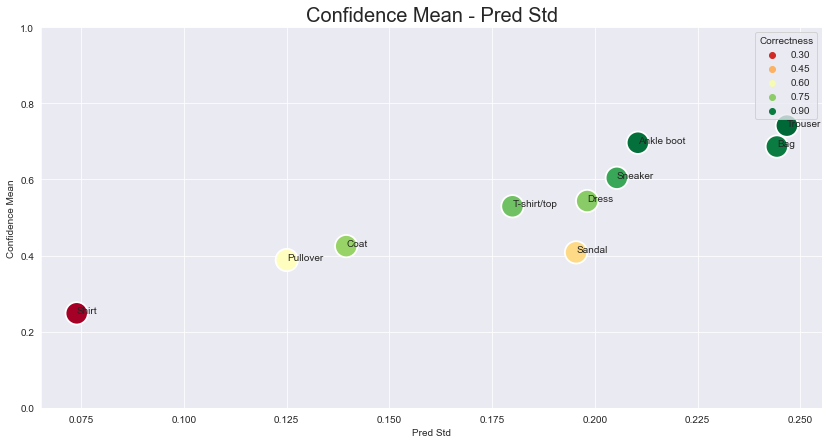

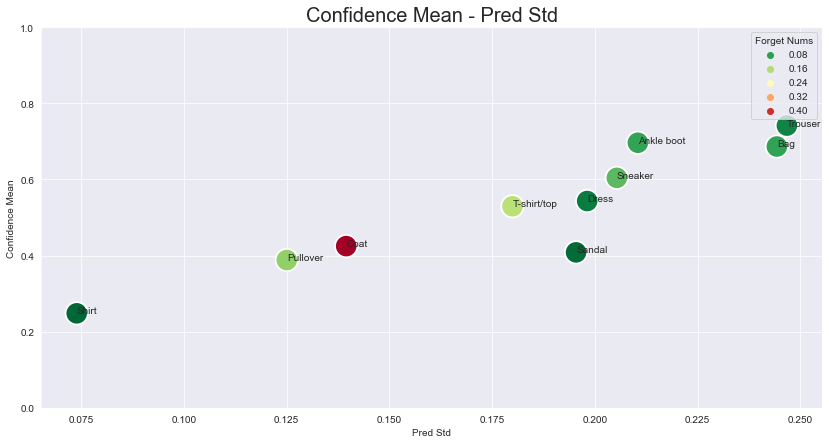

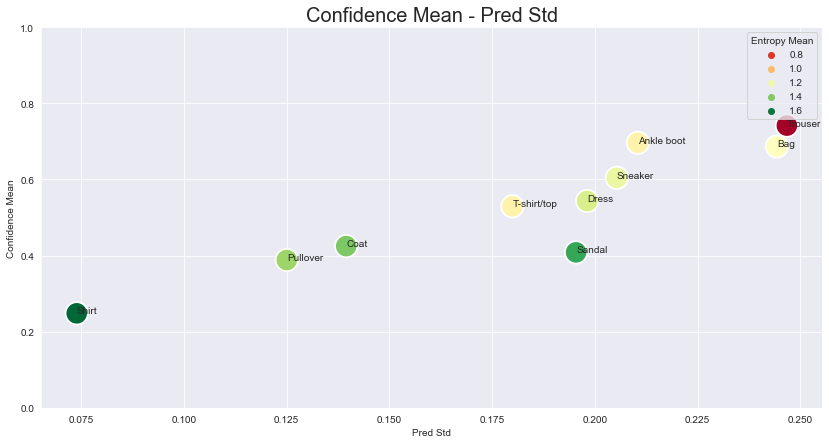

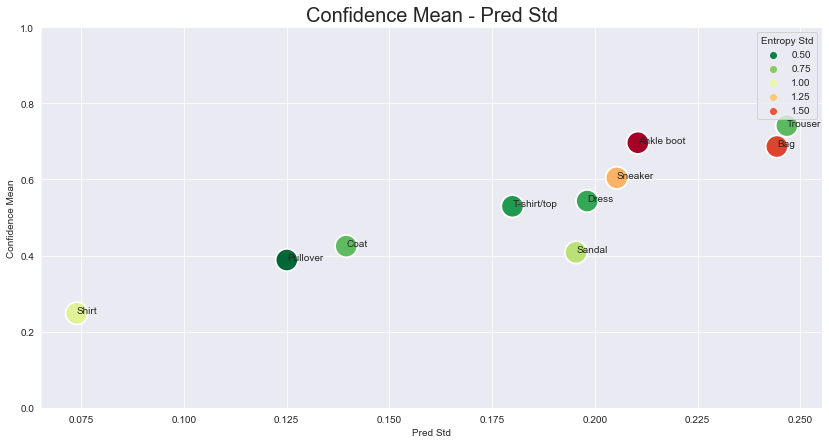

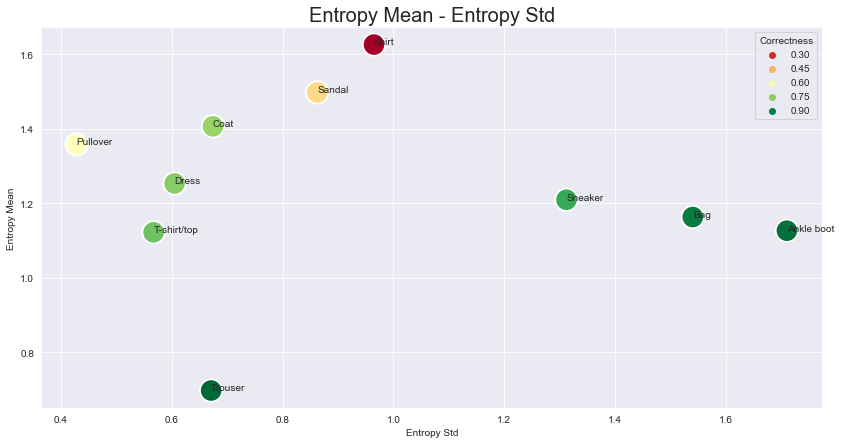

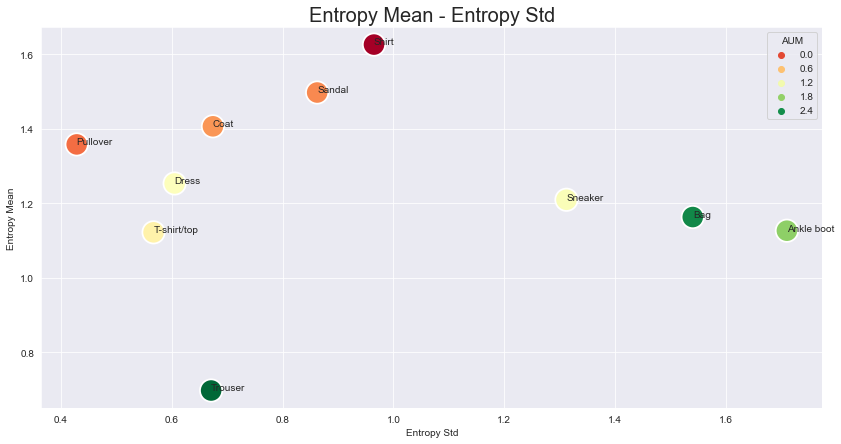

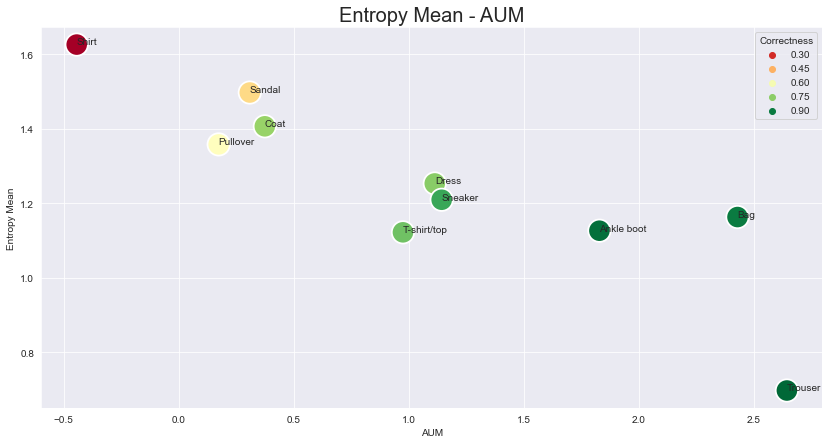

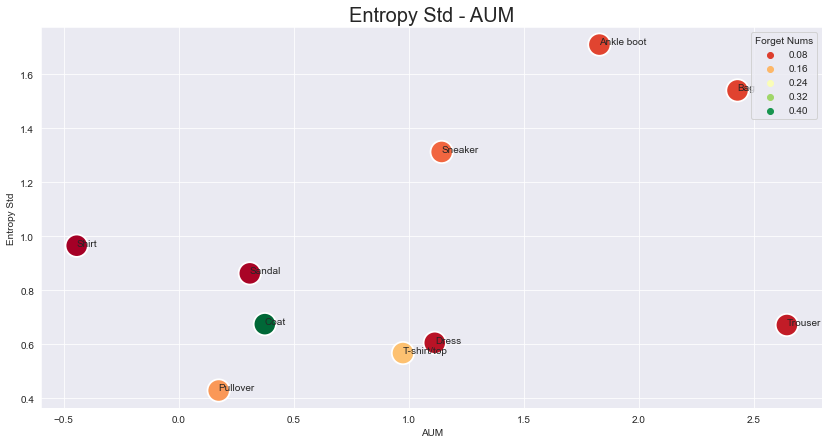

In [13]:
TrainingDynamicsViz.plot_all(training_data)